### NOTES

- There are 3000 events in MC file, while it was generated with 1000 events (revisar!)

- from Thorsten --> We have to find the peak in the "hit_pmt_time" distribution for each slot_id; then, we select a time window @ that particular peak, [-30,+70]ns. Afterwards this "time cuts" have to be applied in e.g. "hit_pmt_charge" distribution. 

- "hit_pmt_charge" units for data is ADC, whereas for MC is PE. No conversion factor available yet.




### ?

- why "hit_pmt_charge" range is (0-1000)(units) ?

- there's a scale factor in MC "hit_pmt_charge" of 160, why this? (to match ADC??)


### CODE

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import uproot
import awkward as ak
%matplotlib inline

In [17]:
data_path = "/dipc/elena/WCTE_2025_commissioning/root_files/data/WCTE_offline_R1711S0_VME1650.root"   #260MeV/c
mc_path = "/dipc/elena/WCTE_2025_commissioning/root_files/mc/pi+_260MeVc_1000evts_masked.root"

data = uproot.open(data_path)
mc = uproot.open(mc_path)

print("Data keys", data.keys())
print("MC keys", mc.keys())

Data keys ['WCTEReadoutWindows;31', 'WCTEReadoutWindows;30', 'h_n_triggers_diff;1']
MC keys ['Tracks;1', 'CherenkovDigiHits;1', 'Trigger;1', 'WCTEReadoutWindows;1']


In [18]:
data_tree = data["WCTEReadoutWindows"]
mc_tree = mc["WCTEReadoutWindows"]

print(f"Data {data_tree}:", sorted(data_tree.keys()))
print(f"MC {mc_tree}:", sorted(mc_tree.keys()))

Data <TTree 'WCTEReadoutWindows' (34 branches) at 0x7f0120586c50>: ['beamline_pmt_qdc_charges', 'beamline_pmt_qdc_ids', 'beamline_pmt_tdc_ids', 'beamline_pmt_tdc_times', 'event_number', 'hit_mpmt_card_ids', 'hit_mpmt_slot_ids', 'hit_pmt_channel_ids', 'hit_pmt_charges', 'hit_pmt_position_ids', 'hit_pmt_times', 'led_card_ids', 'led_counters', 'led_dacsettings', 'led_event_types', 'led_gains', 'led_ids', 'led_sequence_numbers', 'led_slot_numbers', 'led_types', 'pmt_waveform_mpmt_card_ids', 'pmt_waveform_mpmt_slot_ids', 'pmt_waveform_pmt_channel_ids', 'pmt_waveform_pmt_position_ids', 'pmt_waveform_times', 'pmt_waveforms', 'readout_number', 'run_id', 'spill_counter', 'start_counter', 'sub_run_id', 'trigger_times', 'trigger_types', 'window_time']
MC <TTree 'WCTEReadoutWindows' (28 branches) at 0x7f0050a3bbd0>: ['beamline_pmt_qdc_charges', 'beamline_pmt_qdc_ids', 'beamline_pmt_tdc_ids', 'beamline_pmt_tdc_times', 'event_number', 'hit_mpmt_card_ids', 'hit_mpmt_slot_ids', 'hit_pmt_channel_ids', 

In [19]:
#Data 

data_beam_pmt_qdc_ids = data_tree["beamline_pmt_qdc_ids"].array()
data_event_num = data_tree["event_number"].array()

print(data_beam_pmt_qdc_ids)   #array of array, each per event, i.e. jagged array
print(len(data_beam_pmt_qdc_ids)) # number of events in data in this case

print("Type of data_beam_pmt_qdc_ids:", ak.type(data_beam_pmt_qdc_ids))
print("Type of data_event_num:", ak.type(data_event_num))


print("-------------------------------------------------------------------------------------------------")

#MC

mc_beam_pmt_qdc_ids = mc_tree['beamline_pmt_qdc_ids'].array()
mc_event_num = mc_tree["event_number"].array()

print(mc_beam_pmt_qdc_ids)   #array of array, each per event, i.e. jagged array
print(len(mc_beam_pmt_qdc_ids)) # number of events in mc in this case

print("Type of mc_beam_pmt_qdc_ids:", ak.type(mc_beam_pmt_qdc_ids))
print("Type of mc_event_num:", ak.type(mc_event_num))



[[12, 13, 5, 14, 15, 7, 16, 17, 9, 18, ... 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]]
21454
Type of data_beam_pmt_qdc_ids: 21454 * var * int32
Type of data_event_num: 21454 * int32
-------------------------------------------------------------------------------------------------
[[0], [0], [0], [0], [0], [0], [0], [0], ... [0], [0], [0], [0], [0], [0], [0], [0]]
3000
Type of mc_beam_pmt_qdc_ids: 3000 * var * int32
Type of mc_event_num: 3000 * int32


In [20]:
branches = [
    'beamline_pmt_qdc_charges',
    'beamline_pmt_qdc_ids',
    'beamline_pmt_tdc_ids',
    'beamline_pmt_tdc_times',
    'event_number',
    'hit_mpmt_card_ids',
    'hit_mpmt_slot_ids',
    'hit_pmt_channel_ids',
    'hit_pmt_position_ids',
    'hit_pmt_charges',
    'hit_pmt_times',
    'trigger_types',
    'window_time'
]

data_arrays = {name: data_tree[name].array() for name in branches}    #load arrays (branches) from the tree
mc_arrays = {name: mc_tree[name].array() for name in branches}

def make_flat_df(branch_name):
    data_flat = ak.flatten(data_arrays[branch_name], axis=None)
    mc_flat = ak.flatten(mc_arrays[branch_name], axis=None)

    df_data = pd.DataFrame({branch_name: data_flat})
    df_mc = pd.DataFrame({branch_name: mc_flat})

    return df_data, df_mc


df_data = {}
df_mc = {}

for branch in branches:
    df_d, df_m = make_flat_df(branch)
    df_data[branch] = df_d
    df_mc[branch] = df_m



#------------------------------------------------------------------------------------------------------------------------------------------------

#en Awkward Array si estás con datos ROOT, el parámetro axis define en qué nivel del anidamiento quieres operar.
    #axis=0 → Operas a nivel de eventos.
    #axis=1 → Operas a nivel de hits dentro de un evento.
    #axis=None → Operas sobre todos los niveles: aplana completamente la estructura, perdiendo la información de qué hit pertenece a qué evento


In [6]:
print(df_data['hit_pmt_charges'].head())    #MC charge is in PE, in Data is in ADC. No comversion factor to PE available yet 
print(df_data["hit_pmt_charges"].columns)

   hit_pmt_charges
0             74.0
1            218.0
2            196.0
3             63.0
4            236.0
Index(['hit_pmt_charges'], dtype='object')


In [7]:
import sys
sys.path.append("/scratch/elena/WCTE_2025_commissioning/2025_data")
import DataQualityNotebooks.VMEAnalysis as VMEAnalysisModule
import importlib
importlib.reload(VMEAnalysisModule) 
from DataQualityNotebooks.VMEAnalysis import VMEAnalysis


config_file = "/scratch/elena/WCTE_2025_commissioning/config/lep_v51_config.json"
vme_analysis_cut = {
    "t4_qcut": 300,
    "hc0_cut": 150,
    "hc1_cut": 100,
    "act1_ev": 900,
    "act2_pi": 1800,
    "act2_mu_low": 2000,
    "act2_mu_high": 10000,
    "tdc_cut": 200
}

#extract the interesting variables
qdc_charges = data_arrays["beamline_pmt_qdc_charges"]
qdc_ids = data_arrays["beamline_pmt_qdc_ids"]
tdc_times = data_arrays["beamline_pmt_tdc_times"]
tdc_ids = data_arrays["beamline_pmt_tdc_ids"]


#initialize the VMEAnalysis object
vme = VMEAnalysis(config_file, vme_analysis_cut, runNumber=1711)

#load data into the analysis object
q, tdc = vme.load_data(qdc_ids, qdc_charges, tdc_ids, tdc_times)

#apply cuts (mask)
vme.make_cuts_on_data(qdc_ids, qdc_charges, tdc_ids, tdc_times)

#mask for pion-only
pion_mask = vme.getEventMask("pion-only")

#apply mask to the awkward array to filter events
filtered_data_arrays = {
    branch: data_arrays[branch][pion_mask]
    for branch in branches
}

#then convert agin in flatten df and re-named them as df_data
df_data = {
    branch: pd.DataFrame({branch: ak.flatten(filtered_data_arrays[branch], axis=None)})
    for branch in branches
}

number_events = len(df_data['event_number'])

print(f"Selected {number_events} pion-like events")
     


Current Working Directory: /scratch/elena/WCTE-DataAnalysis-PIDcuts/MCDataComperison
[INFO] Total events: 21454
[INFO] Computing activity sums and TOF values...
[INFO] Applying additional cuts...
[INFO] Defining cut sequences...
[INFO] Converting to NumPy for stats...
[INFO] Gathering statistics per cut set...
Selected 336 pion-like events


### PLOTS

##### Charge

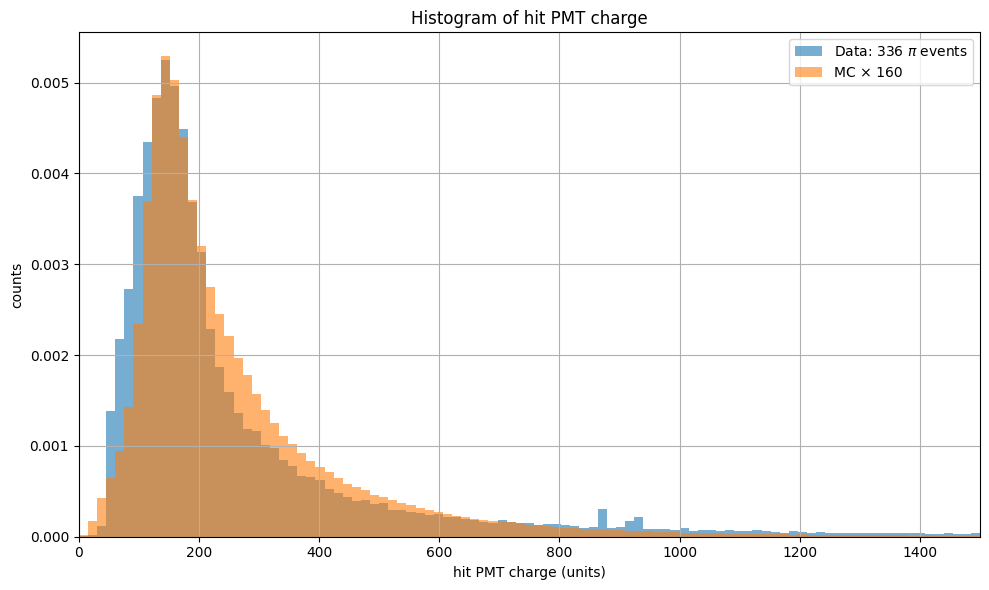

In [8]:
data_charges = df_data["hit_pmt_charges"]
mc_charges = df_mc["hit_pmt_charges"] *160  #scale factor

min_range_charge = 0
max_range_charge = 1500


data_charges = data_charges[(data_charges >= min_range_charge) & (data_charges <= max_range_charge)]
mc_charges = mc_charges[(mc_charges >= min_range_charge) & (mc_charges <= max_range_charge)]

bins = np.linspace(min_range_charge, max_range_charge, 100)


plt.figure(figsize=(10, 6))
plt.hist(data_charges, bins=bins, alpha=0.6, label=f'Data: {number_events} $\pi$ events', histtype='stepfilled', density=True)
plt.hist(mc_charges, bins=bins, alpha=0.6, label='MC × 160', histtype='stepfilled', density=True)

plt.xlabel('hit PMT charge (units)')
plt.ylabel('counts')
plt.title('Histogram of hit PMT charge')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(min_range_charge, max_range_charge)

plt.show()


In [9]:
print("Working with all hits, flattened arrays")
print(f"number of hits in data: {len(data_charges)}")
print(f"number of hits in mc: {len(mc_charges)}")


print("--------------------------------------------------------------------------------------------------------------------------------------")

#if we want to work with total number of events

print("Working with number of events, therefore we sum all hit charge values per event and that's the 'charge_value' for that event")
data_event_charges = ak.sum(data_arrays["hit_pmt_charges"], axis=1)
mc_event_charges = ak.sum(mc_arrays["hit_pmt_charges"], axis=1)

print("PFirst values of charge in data events:", data_event_charges[:10])
print("number of events:", len(data_event_charges))
print("Tipo:", ak.type(data_event_charges))
#-----------------------------------------------------------------------------------------------------------------------------------------------

#now we'll work with the sum of charges per event (axis=1), rather than  individual charge values per hit. 
# This is to have only 44k events for data and apply KDE to find the peaks and calculate the scale factor to match MC and Data (by eye)

Working with all hits, flattened arrays
number of hits in data: 113508
number of hits in mc: 645088
--------------------------------------------------------------------------------------------------------------------------------------
Working with number of events, therefore we sum all hit charge values per event and that's the 'charge_value' for that event
PFirst values of charge in data events: [2.87e+05, 2.96e+05, 6.08e+04, 2.05e+05, ... 2.65e+05, 2.66e+05, 1.15e+05, 4.35e+05]
number of events: 21454
Tipo: 21454 * float32


#### slot_ids

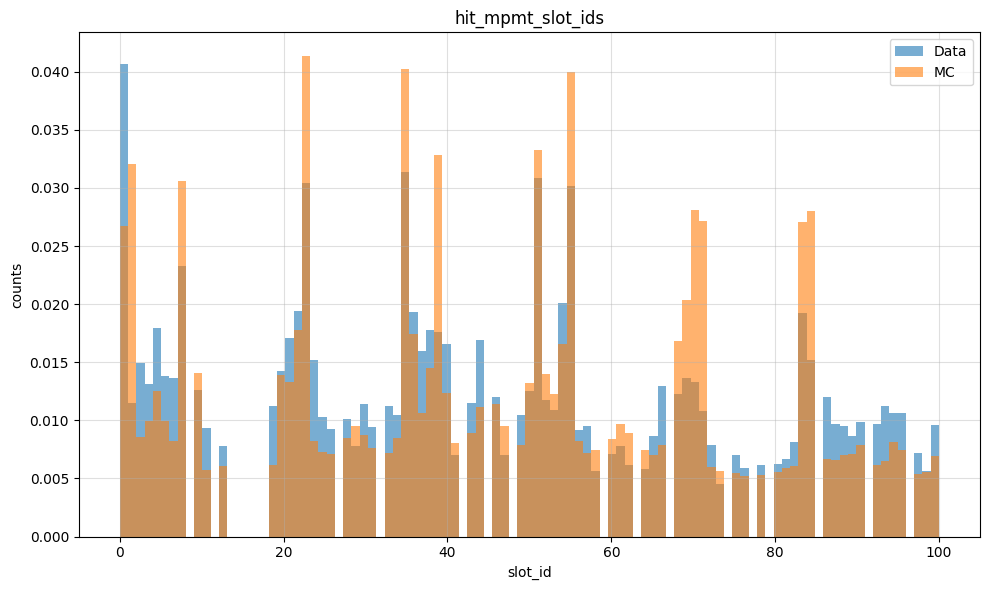

In [10]:
data_slots = df_data["hit_mpmt_slot_ids"]
mc_slots = df_mc["hit_mpmt_slot_ids"]

plt.figure(figsize=(10, 6))

bins = np.linspace(0, 100, 100)

plt.hist(data_slots, bins=bins, alpha=0.6, label='Data', histtype='stepfilled', density=True)
plt.hist(mc_slots, bins=bins, alpha=0.6, label='MC', histtype='stepfilled', density=True)

plt.xlabel('slot_id')
plt.ylabel('counts')
plt.title('hit_mpmt_slot_ids')
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


#### Time

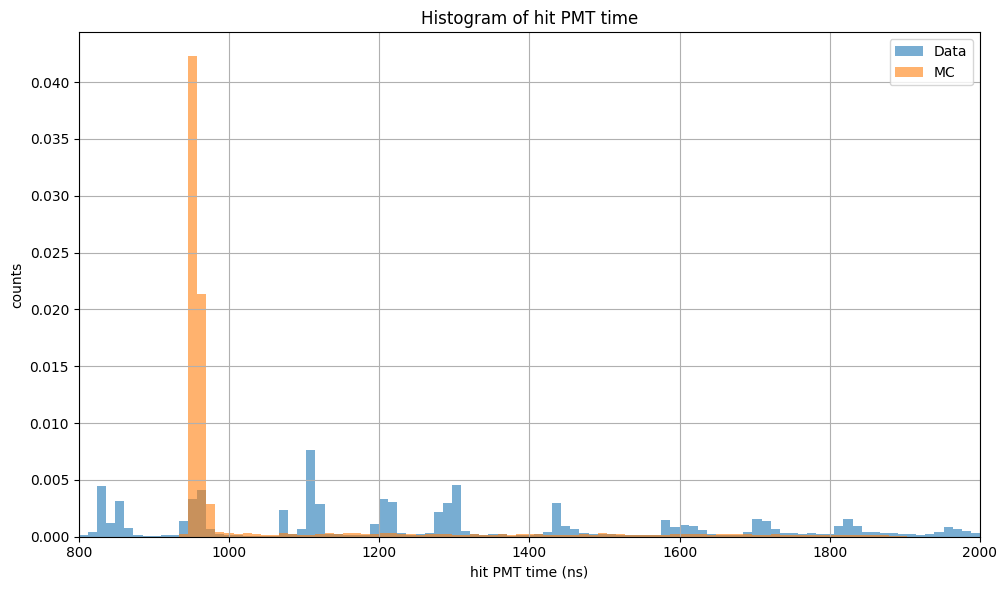

In [11]:
data_times = df_data["hit_pmt_times"]
mc_times = df_mc["hit_pmt_times"]

min_range_time = 800    
max_range_time = 2000   

data_times = data_times[(data_times >= min_range_time) & (data_times <= max_range_time)]
mc_times = mc_times[(mc_times >= min_range_time) & (mc_times <= max_range_time)]

bins = np.linspace(min_range_time, max_range_time, 100)


plt.figure(figsize=(10, 6))
plt.hist(data_times, bins=bins, alpha=0.6, label='Data', histtype='stepfilled', density=True)
plt.hist(mc_times, bins=bins, alpha=0.6, label='MC', histtype='stepfilled', density=True)


plt.xlabel('hit PMT time (ns)')
plt.ylabel('counts')
plt.title('Histogram of hit PMT time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(min_range_time, max_range_time)

plt.show()